Este documento detalha os resultados obtidos através da aplicação do algoritmo `SAC_DM` sobre sinais de geradores de energia eólica. Em um primeiro momento, foi aplicado o SAC_DM sobre o sinal `original`. Já no segundo momento, uma etapa extra foi executada, o sinal foi passado por um filtro `wavelet` antes de ser aplicado ao SAC_DM.

In [1]:
import pywt
import numpy as np
from scipy import signal, stats
from scipy.stats import skew, kurtosis
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import scipy.io as sio
from decimal import Decimal

import sys

from scipy.interpolate import spline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

In [3]:
def upload_signal_np(filename):
    data = np.genfromtxt(filename, delimiter=' ', names=['x', 'y'])
    return data

In [4]:
def upload_signal(filename):
    data = sio.loadmat(filename)
    x_struct = data['tempo']
    y_struct = data['Is']
    data = {'x':[], 'y':[]}
    for i in range(len(y_struct)):
        data['x'].append(x_struct[i, 0])
        data['y'].append(y_struct[i, 0])
    return data

In [5]:
def sac_dm(data, GROUP_SIZE):

	threshold = 0.0

	DATASET_SIZE = len(data['y'])

	rho = 0.0

	GROUP_AMOUNT = 1 + int(DATASET_SIZE)/GROUP_SIZE
	sacdm=[0.0] * int(GROUP_AMOUNT)


	up = 0
	peaks = 0
	i = 1
	n = GROUP_SIZE
	j = 0
	while i < DATASET_SIZE-2:
		a = data['y'][i]
		b = data['y'][i+1]
		c = data['y'][i+2]

		if b > (a+threshold) and b > (c+threshold):
			peaks = peaks + 1
			
		if i == n:
			rho = peaks/float(GROUP_SIZE)

			if rho != 0:
				# sacdm[j] = rho 
				sacdm[j]=1/(6*rho)
			else:
				sacdm[j] = 0
			j = j + 1
			n = n + GROUP_SIZE
			peaks = 0
		i = i+1

	avg = sum(sacdm)/len(sacdm)
	print("sacdm min: ", min(sacdm), ", sacdm max: ", max(sacdm))
	print("Average: ", avg)
	return sacdm, avg

In [6]:
def mean_var_pder(signal):
    return np.mean(signal), np.var(signal), np.std(signal)


# Tipos de Defeitos

Defeito 1 (**D1**) – curto-circuito entre espiras

Defeito 2 (**D2**) – curto-circuito espira-terra (espira-carcaça)

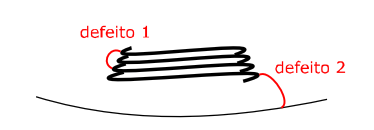

In [7]:
from IPython.display import Image, display

#Read image
display(Image(filename = "defeitos.png"))


# Upload dos sinais

In [8]:
data_on = upload_signal("dados/C100_F5k_ON.mat") #Sem defeito

data_d1_p1_r1 = upload_signal("dados/C100_F5k_D1_P1_R1.mat")
data_d2_p1_r1 = upload_signal("dados/C100_F5k_D2_P1_R1.mat")

data_d1_p1_r2 = upload_signal("dados/C100_F5k_D1_P1_R2.mat")
data_d2_p1_r2 = upload_signal("dados/C100_F5k_D2_P1_R2.mat")

data_d1_p2_r1 = upload_signal("dados/C100_F5k_D1_P2_R1.mat")
data_d2_p2_r1 = upload_signal("dados/C100_F5k_D2_P2_R1.mat")

data_d1_p2_r2 = upload_signal("dados/C100_F5k_D1_P2_R2.mat")
data_d2_p2_r2 = upload_signal("dados/C100_F5k_D2_P2_R2.mat")

data_d1_p3_r1 = upload_signal("dados/C100_F5k_D1_P3_R1.mat")
data_d2_p3_r1 = upload_signal("dados/C100_F5k_D2_P3_R1.mat")

data_d1_p3_r2 = upload_signal("dados/C100_F5k_D1_P3_R2.mat")
data_d2_p3_r2 = upload_signal("dados/C100_F5k_D2_P3_R2.mat")

data_d1_p4_r1 = upload_signal("dados/C100_F5k_D1_P4_R1.mat")
data_d2_p4_r1 = upload_signal("dados/C100_F5k_D2_P4_R1.mat")

data_d1_p4_r2 = upload_signal("dados/C100_F5k_D1_P4_R2.mat")
data_d2_p4_r2 = upload_signal("dados/C100_F5k_D2_P4_R2.mat")

data_d1_p5_r1 = upload_signal("dados/C100_F5k_D1_P5_R1.mat")
data_d2_p5_r1 = upload_signal("dados/C100_F5k_D2_P5_R1.mat")

data_d1_p5_r2 = upload_signal("dados/C100_F5k_D1_P5_R2.mat")
data_d2_p5_r2 = upload_signal("dados/C100_F5k_D2_P5_R2.mat")

data_d1_p6_r1 = upload_signal("dados/C100_F5k_D1_P6_R1.mat")
data_d2_p6_r1 = upload_signal("dados/C100_F5k_D2_P6_R1.mat")

data_d1_p6_r2 = upload_signal("dados/C100_F5k_D1_P6_R2.mat")
data_d2_p6_r2 = upload_signal("dados/C100_F5k_D2_P6_R2.mat")

data_d1_p7_r1 = upload_signal("dados/C100_F5k_D1_P7_R1.mat")
data_d2_p7_r1 = upload_signal("dados/C100_F5k_D2_P7_R1.mat")

data_d1_p7_r2 = upload_signal("dados/C100_F5k_D1_P7_R2.mat")
data_d2_p7_r2 = upload_signal("dados/C100_F5k_D2_P7_R2.mat")

data_d1_p8_r1 = upload_signal("dados/C100_F5k_D1_P8_R1.mat")
data_d2_p8_r1 = upload_signal("dados/C100_F5k_D2_P8_R1.mat")

data_d1_p8_r2 = upload_signal("dados/C100_F5k_D1_P8_R2.mat")
data_d2_p8_r2 = upload_signal("dados/C100_F5k_D2_P8_R2.mat")

data_d1_p9_r1 = upload_signal("dados/C100_F5k_D1_P9_R1.mat")
data_d2_p9_r1 = upload_signal("dados/C100_F5k_D2_P9_R1.mat")

data_d1_p9_r2 = upload_signal("dados/C100_F5k_D1_P9_R2.mat")
data_d2_p9_r2 = upload_signal("dados/C100_F5k_D2_P9_R2.mat")

data_d1_p10_r1 = upload_signal("dados/C100_F5k_D1_P10_R1.mat")
data_d2_p10_r1 = upload_signal("dados/C100_F5k_D2_P10_R1.mat")

data_d1_p10_r2 = upload_signal("dados/C100_F5k_D1_P10_R2.mat")
data_d2_p10_r2 = upload_signal("dados/C100_F5k_D2_P10_R2.mat")


# Aplicação do SAC_DM

In [9]:
GROUP_SIZE = 1000
avg_amount = []

print("ON")
#ON
sac_on, avg = sac_dm(data_on, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P1_R1")
#D1_P1_R1
sac_d1_p1_r1, avg = sac_dm(data_d1_p1_r1, GROUP_SIZE)
avg_amount.append(avg)
avg_d1 = avg
#D2_P1_R1
sac_d2_p1_r1, avg = sac_dm(data_d2_p1_r1, GROUP_SIZE)
avg_amount.append(avg)
avg_d2 = avg
print("\n")

print("P1_R2")
#D1_P1_R2
sac_d1_p1_r2, avg = sac_dm(data_d1_p1_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P1_R2
sac_d2_p1_r2, avg = sac_dm(data_d2_p1_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P2_R1")
#D1_P2_R1
sac_d1_p2_r1, avg = sac_dm(data_d1_p2_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P2_R1
sac_d2_p2_r1, avg = sac_dm(data_d2_p2_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P2_R2")
#D1_P2_R2
sac_d1_p2_r2, avg = sac_dm(data_d1_p2_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P2_R2
sac_d2_p2_r2, avg = sac_dm(data_d2_p2_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P3_R1")
#D1_P3_R1
sac_d1_p3_r1, avg = sac_dm(data_d1_p3_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P3_R1
sac_d2_p3_r1, avg = sac_dm(data_d2_p3_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P3_R2")
#D1_P3_R2
sac_d1_p3_r2, avg = sac_dm(data_d1_p3_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P3_R2
sac_d2_p3_r2, avg = sac_dm(data_d2_p3_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P4_R1")
#D1_P4_R1
sac_d1_p4_r1, avg = sac_dm(data_d1_p4_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P4_R1
sac_d2_p4_r1, avg = sac_dm(data_d2_p4_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P4_R2")
#D1_P4_R2
sac_d1_p4_r2, avg = sac_dm(data_d1_p4_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P4_R2
sac_d2_p4_r2, avg = sac_dm(data_d2_p4_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P5_R1")
#D1_P5_R1
sac_d1_p5_r1, avg = sac_dm(data_d1_p5_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P5_R1
sac_d2_p5_r1, avg = sac_dm(data_d2_p5_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P5_R2")
#D1_P5_R2
sac_d1_p5_r2, avg = sac_dm(data_d1_p5_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P5_R2
sac_d2_p5_r2, avg = sac_dm(data_d2_p5_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P6_R1")
#D1_P6_R1
sac_d1_p6_r1, avg = sac_dm(data_d1_p6_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P6_R1
sac_d2_p6_r1, avg = sac_dm(data_d2_p6_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P6_R2")
#D1_P6_R2
sac_d1_p6_r2, avg = sac_dm(data_d1_p6_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P6_R2
sac_d2_p6_r2, avg = sac_dm(data_d2_p6_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P7_R1")
#D1_P7_R1
sac_d1_p7_r1, avg = sac_dm(data_d1_p7_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P7_R1
sac_d2_p7_r1, avg = sac_dm(data_d2_p7_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P7_R2")
#D1_P7_R2
sac_d1_p7_r2, avg = sac_dm(data_d1_p7_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P2_R2
sac_d2_p7_r2, avg = sac_dm(data_d2_p7_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P8_R1")
#D1_P8_R1
sac_d1_p8_r1, avg = sac_dm(data_d1_p8_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P8_R1
sac_d2_p8_r1, avg = sac_dm(data_d2_p8_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P8_R2")
#D1_P8_R2
sac_d1_p8_r2, avg = sac_dm(data_d1_p8_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P8_R2
sac_d2_p8_r2, avg = sac_dm(data_d2_p8_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P9_R1")
#D1_P9_R1
sac_d1_p9_r1, avg = sac_dm(data_d1_p9_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P9_R1
sac_d2_p9_r1, avg = sac_dm(data_d2_p9_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P9_R2")
#D1_P9_R2
sac_d1_p9_r2, avg = sac_dm(data_d1_p9_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P9_R2
sac_d2_p9_r2, avg = sac_dm(data_d2_p9_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P10_R1")
#D1_P10_R1
sac_d1_p10_r1, avg = sac_dm(data_d1_p10_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P10_R1
sac_d2_p10_r1, avg = sac_dm(data_d2_p10_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")
from numpy import mean, var

print("P10_R2")
#D1_P10_R2
sac_d1_p10_r2, avg = sac_dm(data_d1_p10_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P10_R2
sac_d2_p10_r2, avg = sac_dm(data_d2_p10_r2, GROUP_SIZE)
avg_amount.append(avg)

ON
sacdm min:  0.0 , sacdm max:  3.9682539682539684
Average:  3.312019190216666


P1_R1
sacdm min:  0.0 , sacdm max:  2.73224043715847
Average:  2.3908570997944354
sacdm min:  0.0 , sacdm max:  2.73224043715847
Average:  2.3915652970525447


P1_R2
sacdm min:  0.0 , sacdm max:  2.6455026455026456
Average:  2.3069813462351796
sacdm min:  0.0 , sacdm max:  2.6455026455026456
Average:  2.305708289621963


P2_R1
sacdm min:  0.0 , sacdm max:  2.923976608187134
Average:  2.5744281963101416
sacdm min:  0.0 , sacdm max:  2.923976608187134
Average:  2.573813360189231


P2_R2
sacdm min:  0.0 , sacdm max:  2.923976608187134
Average:  2.5673057837232074
sacdm min:  0.0 , sacdm max:  2.923976608187134
Average:  2.5683460215620677


P3_R1
sacdm min:  0.0 , sacdm max:  3.0864197530864197
Average:  2.8254244673607203
sacdm min:  0.0 , sacdm max:  3.0864197530864197
Average:  2.8239854931775046


P3_R2
sacdm min:  0.0 , sacdm max:  3.0864197530864197
Average:  2.655861640374045
sacdm min:  0.0 , sacdm m

# Média, Variância e Desvio padrão

In [10]:
print(mean_var_pder(sac_on))
print(mean_var_pder(sac_d1_p1_r1))
print(mean_var_pder(sac_d1_p1_r2))
print(mean_var_pder(sac_d1_p5_r1))
print(mean_var_pder(sac_d1_p5_r2))
print(mean_var_pder(sac_d1_p10_r1))
print(mean_var_pder(sac_d1_p10_r2))

(3.3120191902166236, 0.024216177751660944, 0.15561548043707266)
(2.390857099794452, 0.017040858071738222, 0.13054063762575324)
(2.3069813462352022, 0.01534381709503427, 0.12387016224674233)
(3.2256606614605907, 0.032000089555800734, 0.17888568851588083)
(3.016569125530581, 0.025673303012783342, 0.16022890816823082)
(4.902110700624635, 0.16258301579611936, 0.4032158426898915)
(3.64704653448606, 0.05273548366682768, 0.2296420773003669)


# Z score

Calcula o Z score de cada valor na amostra, padronizado pela média e desvio padrão da amostra.

In [11]:
display(Image(url = "https://wikimedia.org/api/rest_v1/media/math/render/svg/2a57dce06002417246b3193d6517f4072765b0c7"))

# Médias obtidas

In [104]:
sacdm_layout = go.Layout(
    
    legend=dict(
        y=1,
        traceorder='reversed',
        font=dict(
            size=12
        )
        ),
    
    
    title='Signals',
    titlefont=dict(
#             family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
    xaxis=dict(
        title='Short Circuit Percentage',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#000000'
        )
    ),
    yaxis=dict(
        title='SAC-DM',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#000000'
        )
    )
)

In [71]:
avg_layout = go.Layout(
    title='Averages',
    titlefont=dict(
#             family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
    xaxis=dict(
        title='Sample',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    ),
    yaxis=dict(
        title='Avg',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    )
)
iplot({
    "data":[go.Scatter(
        x=['ON',
           'D1_P1_R1','D2_P1_R1',
           'D1_P1_R2','D2_P1_R2',
           'D1_P2_R1','D2_P2_R1',
           'D1_P2_R2','D2_P2_R2',
           'D1_P3_R1','D2_P3_R1',
           'D1_P3_R2','D2_P3_R2',
           'D1_P4_R1','D2_P4_R1',
           'D1_P4_R2','D2_P4_R2',
           'D1_P5_R1','D2_P5_R1',
           'D1_P5_R2','D2_P5_R2',
           'D1_P6_R1','D2_P6_R1',
           'D1_P6_R2','D2_P6_R2',
           'D1_P7_R1','D2_P7_R1',
           'D1_P7_R2','D2_P7_R2',
           'D1_P8_R1','D2_P8_R1',
           'D1_P8_R2','D2_P8_R2',
           'D1_P9_R1','D2_P9_R1',
           'D1_P9_R2','D2_P9_R2',
           'D1_P10_R1','D2_P10_R1',
           'D1_P10_R2','D2_P10_R2'],
        y=avg_amount)],
    "layout":sacdm_layout
})

# Médias de R1

In [14]:
r1_avg = []
r1_avg.append(avg_amount[0])
for i in range(1, len(avg_amount), 4):
    r1_avg.append(avg_amount[i])
#     r1_avg.append(avg_amount[i+1])
print(len(r1_avg))


iplot({
    "data":[go.Scatter(
        x=[
            'ON',
           'D1_P1_R1',#'D2_P1_R1',
#            'D1_P1_R2',#'D2_P1_R2',
           'D1_P2_R1',#'D2_P2_R1',
#            'D1_P2_R2',#'D2_P2_R2',
           'D1_P3_R1',#'D2_P3_R1',
#            'D1_P3_R2',#'D2_P3_R2',
           'D1_P4_R1',#'D2_P4_R1',
#            'D1_P4_R2',#'D2_P4_R2',
           'D1_P5_R1',#'D2_P5_R1',
#            'D1_P5_R2',#'D2_P5_R2',
           'D1_P6_R1',#'D2_P6_R1',
#            'D1_P6_R2',#'D2_P6_R2',
           'D1_P7_R1',#'D2_P7_R1',
#            'D1_P7_R2',#'D2_P7_R2',
           'D1_P8_R1',#'D2_P8_R1',
#            'D1_P8_R2',#'D2_P8_R2',
           'D1_P9_R1',#'D2_P9_R1',
#            'D1_P9_R2',#'D2_P9_R2',
           'D1_P10_R1',#'D2_P10_R1',
#            'D1_P10_R2',#'D2_P10_R2'
        ],
        y=r1_avg)
        ],
    "layout":sacdm_layout
})

11


In [15]:
y0 = sac_on
y1 = sac_d1_p6_r1

trace0 = go.Box(
    y=y0
)
trace1 = go.Box(
    y=y1
)
data = [trace0, trace1]
iplot(data)

# SAC-DM x Percentual de espiras em curto

In [110]:
r1_avg = []
normal = []
normal.append(avg_amount[0])
for i in range(1, len(avg_amount), 4):
    r1_avg.append(avg_amount[i])
#     r1_avg.append(avg_amount[i+1])
print(len(r1_avg))

r2_avg = []
for i in range(3, len(avg_amount), 4):
    r2_avg.append(avg_amount[i])
#     r2_avg.append(avg_amount[i+1])
print(len(r2_avg))

iplot({
    "data":[go.Scatter(
        x=['normal'],
        y=normal,
        mode = 'markers',
        name = 'Operação normal'),
            
            go.Scatter(
        x=[
#             'D1_P1_R1',
#             'D2_P1_R1',
            'P1',
#             'D2_P1_R2',
#             'D1_P2_R1',
#             'D2_P2_R1',
            'P2',
#             'D2_P2_R2',
#             'D1_P3_R1',
#             'D2_P3_R1',
            'P3',
#             'D2_P3_R2',
#             'D1_P4_R1',
#             'D2_P4_R1',
            'P4',
#             'D2_P4_R2',
#             'D1_P5_R1',
#             'D2_P5_R1',
            'P5',
#             'D2_P5_R2',
#             'D1_P6_R1',
#             'D2_P6_R1',
            'P6',
#             'D2_P6_R2',
#             'D1_P7_R1',
#             'D2_P7_R1',
            'P7',
#             'D2_P7_R2',
#             'D1_P8_R1',
#             'D2_P8_R1',
            'P8',
#             'D2_P8_R2',
#             'D1_P9_R1',
#             'D2_P9_R1',
            'P9',
#             'D2_P9_R2',
#             'D1_P10_R1',
#             'D2_P10_R1',
            'P10',
#             'D2_P10_R2'
            ],
        y=r2_avg,
        mode = 'lines+markers',
        name = '2% Resistance'),
            
            
            go.Scatter(
        x=[
           'P1',#'D2_P1_R1',
#            'D1_P1_R2',#'D2_P1_R2',
           'P2',#'D2_P2_R1',
#            'D1_P2_R2',#'D2_P2_R2',
           'P3',#'D2_P3_R1',
#            'D1_P3_R2',#'D2_P3_R2',
           'P4',#'D2_P4_R1',
#            'D1_P4_R2',#'D2_P4_R2',
           'P5',#'D2_P5_R1',
#            'D1_P5_R2',#'D2_P5_R2',
           'P6',#'D2_P6_R1',
#            'D1_P6_R2',#'D2_P6_R2',
           'P7',#'D2_P7_R1',
#            'D1_P7_R2',#'D2_P7_R2',
           'P8',#'D2_P8_R1',
#            'D1_P8_R2',#'D2_P8_R2',
           'P9',#'D2_P9_R1',
#            'D1_P9_R2',#'D2_P9_R2',
           'P10',#'D2_P10_R1',
#            'D1_P10_R2',#'D2_P10_R2'
        ],
        y=r1_avg,
        mode = 'lines+markers',
        name = '1% Resistance')     
           ],
    "layout":sacdm_layout
})

10
10


# SAC-DM x Skeulers

In [77]:
r1_avg = []
r1_avg.append(skew(sac_on))
r1_avg.append(skew(sac_d1_p1_r1))
r1_avg.append(skew(sac_d1_p2_r1))
r1_avg.append(skew(sac_d1_p3_r1))
r1_avg.append(skew(sac_d1_p4_r1))
r1_avg.append(skew(sac_d1_p5_r1))
r1_avg.append(skew(sac_d1_p6_r1))
r1_avg.append(skew(sac_d1_p7_r1))
r1_avg.append(skew(sac_d1_p8_r1))
r1_avg.append(skew(sac_d1_p9_r1))
r1_avg.append(skew(sac_d1_p10_r1))

r2_avg = []
r2_avg.append(skew(sac_on))
r2_avg.append(skew(sac_d1_p1_r2))
r2_avg.append(skew(sac_d1_p2_r2))
r2_avg.append(skew(sac_d1_p3_r2))
r2_avg.append(skew(sac_d1_p4_r2))
r2_avg.append(skew(sac_d1_p5_r2))
r2_avg.append(skew(sac_d1_p6_r2))
r2_avg.append(skew(sac_d1_p7_r2))
r2_avg.append(skew(sac_d1_p8_r2))
r2_avg.append(skew(sac_d1_p9_r2))
r2_avg.append(skew(sac_d1_p10_r2))

iplot({
    "data":[go.Scatter(
        x=[
            '0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '10',
            ],
        y=r2_avg,
        mode = 'lines+markers',
        name = '2% Resistance'),
           
           
            go.Scatter(
        x=[
            '0',
           '1',#'D2_P1_R1',
           '2',#'D2_P2_R1',
           '3',#'D2_P3_R1',
           '4',#'D2_P4_R1',
           '5',#'D2_P5_R1',
           '6',#'D2_P6_R1',
           '7',#'D2_P7_R1',
           '8',#'D2_P8_R1',
           '9',#'D2_P9_R1',
           '10',#'D2_P10_R1',
        ],
        y=r1_avg,
        mode = 'lines+markers',
        name = '1% Resistance')     
           ],
    "layout":sacdm_layout
})

# SAC-DM x Curtose

In [69]:
print(avg_amount[0])
print(kurtosis(avg_amount[0]))
print(r1_avg)

3.312019190216666
-3.0
[-3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0]


In [78]:
r1_avg = []
r1_avg.append(kurtosis(sac_on))
r1_avg.append(kurtosis(sac_d1_p1_r1))
r1_avg.append(kurtosis(sac_d1_p2_r1))
r1_avg.append(kurtosis(sac_d1_p3_r1))
r1_avg.append(kurtosis(sac_d1_p4_r1))
r1_avg.append(kurtosis(sac_d1_p5_r1))
r1_avg.append(kurtosis(sac_d1_p6_r1))
r1_avg.append(kurtosis(sac_d1_p7_r1))
r1_avg.append(kurtosis(sac_d1_p8_r1))
r1_avg.append(kurtosis(sac_d1_p9_r1))
r1_avg.append(kurtosis(sac_d1_p10_r1))

r2_avg = []
r2_avg.append(kurtosis(sac_on))
r2_avg.append(kurtosis(sac_d1_p1_r2))
r2_avg.append(kurtosis(sac_d1_p2_r2))
r2_avg.append(kurtosis(sac_d1_p3_r2))
r2_avg.append(kurtosis(sac_d1_p4_r2))
r2_avg.append(kurtosis(sac_d1_p5_r2))
r2_avg.append(kurtosis(sac_d1_p6_r2))
r2_avg.append(kurtosis(sac_d1_p7_r2))
r2_avg.append(kurtosis(sac_d1_p8_r2))
r2_avg.append(kurtosis(sac_d1_p9_r2))
r2_avg.append(kurtosis(sac_d1_p10_r2))

iplot({
    "data":[go.Scatter(
        x=[
            '0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '10',
            ],
        y=r2_avg,
        mode = 'lines+markers',
        name = '2% Resistance'),
           
           
            go.Scatter(
        x=[
            '0',
           '1',#'D2_P1_R1',
           '2',#'D2_P2_R1',
           '3',#'D2_P3_R1',
           '4',#'D2_P4_R1',
           '5',#'D2_P5_R1',
           '6',#'D2_P6_R1',
           '7',#'D2_P7_R1',
           '8',#'D2_P8_R1',
           '9',#'D2_P9_R1',
           '10',#'D2_P10_R1',
        ],
        y=r1_avg,
        mode = 'lines+markers',
        name = '1% Resistance')     
           ],
    "layout":sacdm_layout
})

In [17]:
cor_layout = go.Layout(
    title='Signal',
    xaxis=dict(
        title='Time (ms)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Correlation Length',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

# Plotando todos os sinais após o SAC_DM

In [18]:
#The 'C100_F5k_' prefix has been removed for easy reading

g_on = go.Scatter(name="ON", y=sac_on)

g_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_d1_p1_r1)
g_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_d2_p1_r1)

g_d1_p1_r2 = go.Scatter(name="D1_P1_R2", y=sac_d1_p1_r2)
g_d2_p1_r2 = go.Scatter(name="D2_P1_R2", y=sac_d2_p1_r2)

g_d1_p2_r1 = go.Scatter(name="D1_P2_R1", y=sac_d1_p2_r1)
g_d2_p2_r1 = go.Scatter(name="D2_P2_R1", y=sac_d2_p2_r1)

g_d1_p2_r2 = go.Scatter(name="D1_P2_R2", y=sac_d1_p2_r2)
g_d2_p2_r2 = go.Scatter(name="D2_P2_R2", y=sac_d2_p2_r2)

g_d1_p3_r1 = go.Scatter(name="D1_P3_R1", y=sac_d1_p3_r1)
g_d2_p3_r1 = go.Scatter(name="D2_P3_R1", y=sac_d2_p3_r1)

g_d1_p3_r2 = go.Scatter(name="D1_P3_R2", y=sac_d1_p3_r2)
g_d2_p3_r2 = go.Scatter(name="D2_P3_R2", y=sac_d2_p3_r2)

g_d1_p4_r1 = go.Scatter(name="D1_P4_R1", y=sac_d1_p4_r1)
g_d2_p4_r1 = go.Scatter(name="D2_P4_R1", y=sac_d2_p4_r1)

g_d1_p4_r2 = go.Scatter(name="D1_P4_R2", y=sac_d1_p4_r2)
g_d2_p4_r2 = go.Scatter(name="D2_P4_R2", y=sac_d2_p4_r2)

g_d1_p5_r1 = go.Scatter(name="D1_P5_R1", y=sac_d1_p5_r1)
g_d2_p5_r1 = go.Scatter(name="D2_P5_R1", y=sac_d2_p5_r1)

g_d1_p5_r2 = go.Scatter(name="D1_P5_R2", y=sac_d1_p5_r2)
g_d2_p5_r2 = go.Scatter(name="D2_P5_R2", y=sac_d2_p5_r2)

g_d1_p6_r1 = go.Scatter(name="D1_P6_R1", y=sac_d1_p6_r1)
g_d2_p6_r1 = go.Scatter(name="D2_P6_R1", y=sac_d2_p6_r1)

g_d1_p6_r2 = go.Scatter(name="D1_P6_R2", y=sac_d1_p6_r2)
g_d2_p6_r2 = go.Scatter(name="D2_P6_R2", y=sac_d2_p6_r2)

g_d1_p7_r1 = go.Scatter(name="D1_P7_R1", y=sac_d1_p7_r1)
g_d2_p7_r1 = go.Scatter(name="D2_P7_R1", y=sac_d2_p7_r1)

g_d1_p7_r2 = go.Scatter(name="D1_P7_R2", y=sac_d1_p7_r2)
g_d2_p7_r2 = go.Scatter(name="D2_P7_R2", y=sac_d2_p7_r2)

g_d1_p8_r1 = go.Scatter(name="D1_P8_R1", y=sac_d1_p8_r1)
g_d2_p8_r1 = go.Scatter(name="D2_P8_R1", y=sac_d2_p8_r1)

g_d1_p8_r2 = go.Scatter(name="D1_P8_R2", y=sac_d1_p8_r2)
g_d2_p8_r2 = go.Scatter(name="D2_P8_R2", y=sac_d2_p8_r2)

g_d1_p9_r1 = go.Scatter(name="D1_P9_R1", y=sac_d1_p9_r1)
g_d2_p9_r1 = go.Scatter(name="D2_P9_R1", y=sac_d2_p9_r1)

g_d1_p9_r2 = go.Scatter(name="D1_P9_R2", y=sac_d1_p9_r2)
g_d2_p9_r2 = go.Scatter(name="D2_P9_R2", y=sac_d2_p9_r2)

g_d1_p10_r1 = go.Scatter(name="D1_P10_R1", y=sac_d1_p10_r1)
g_d2_p10_r1 = go.Scatter(name="D2_P10_R1", y=sac_d2_p10_r1)

g_d1_p10_r2 = go.Scatter(name="D1_P10_R2", y=sac_d1_p10_r2)
g_d2_p10_r2 = go.Scatter(name="D2_P10_R2", y=sac_d2_p10_r2)


iplot({
    'data': [
                g_on,
                g_d1_p1_r1, g_d2_p1_r1,
                g_d1_p1_r2, g_d2_p1_r2, 
                g_d1_p2_r1, g_d2_p2_r1, 
                g_d1_p2_r2, g_d2_p2_r2,
                g_d1_p3_r1, g_d2_p3_r1,
                g_d1_p3_r2, g_d2_p3_r2,
                g_d1_p4_r1, g_d2_p4_r1,
                g_d1_p4_r2, g_d2_p4_r2,
                g_d1_p5_r1, g_d2_p5_r1,
                g_d1_p5_r2, g_d2_p5_r2,
                g_d1_p6_r1, g_d2_p6_r1,
                g_d1_p6_r2, g_d2_p6_r2,
                g_d1_p7_r1, g_d2_p7_r1,
                g_d1_p7_r2, g_d2_p7_r2,
                g_d1_p8_r1, g_d2_p8_r1,
                g_d1_p8_r2, g_d2_p8_r2,
                g_d1_p9_r1, g_d2_p9_r1,
                g_d1_p9_r2, g_d2_p9_r2,
                g_d1_p10_r1, g_d2_p10_r1,
                g_d1_p10_r2, g_d2_p10_r2
            ],
    'layout': sacdm_layout})

In [19]:
g_no = go.Scatter(name="Normal Operation", y=sac_on)

iplot({
    'data': [
                g_no,
                g_d1_p1_r1,
                g_d1_p1_r2,
                
                g_d1_p3_r1,
                g_d1_p3_r2,
                
                g_d1_p9_r1,
                g_d1_p9_r2
            ],
    'layout': sacdm_layout})

# Z score

In [20]:
print('skew')
print(skew(stats.zscore(sac_on)))
print()

print(skew(stats.zscore(sac_d1_p1_r1)))
print(skew(stats.zscore(sac_d2_p1_r1)))
print()
print(skew(stats.zscore(sac_d1_p1_r2)))
print(skew(stats.zscore(sac_d2_p1_r2)))
print()

print(skew(stats.zscore(sac_d1_p2_r1)))
print(skew(stats.zscore(sac_d2_p2_r1)))
print()
print(skew(stats.zscore(sac_d1_p2_r2)))
print(skew(stats.zscore(sac_d2_p2_r2)))
print()


print(skew(stats.zscore(sac_d1_p3_r1)))
print(skew(stats.zscore(sac_d2_p3_r1)))
print()
print(skew(stats.zscore(sac_d1_p3_r2)))
print(skew(stats.zscore(sac_d2_p3_r2)))
print()


print(skew(stats.zscore(sac_d1_p4_r1)))
print(skew(stats.zscore(sac_d2_p4_r1)))
print()
print(skew(stats.zscore(sac_d1_p4_r2)))
print(skew(stats.zscore(sac_d2_p4_r2)))
print()


print(skew(stats.zscore(sac_d1_p5_r1)))
print(skew(stats.zscore(sac_d2_p5_r1)))
print()
print(skew(stats.zscore(sac_d1_p5_r2)))
print(skew(stats.zscore(sac_d2_p5_r2)))
print()


print(skew(stats.zscore(sac_d1_p7_r1)))
print(skew(stats.zscore(sac_d2_p7_r1)))
print()
print(skew(stats.zscore(sac_d1_p7_r1)))
print(skew(stats.zscore(sac_d2_p7_r1)))
print()


print(skew(stats.zscore(sac_d1_p9_r1)))
print(skew(stats.zscore(sac_d2_p9_r1)))
print()
print(skew(stats.zscore(sac_d1_p9_r2)))
print(skew(stats.zscore(sac_d2_p9_r2)))
print()

print(skew(stats.zscore(sac_d1_p10_r1)))
print(skew(stats.zscore(sac_d2_p10_r1)))
print()
print(skew(stats.zscore(sac_d1_p10_r1)))
print(skew(stats.zscore(sac_d2_p10_r1)))
print()

print('_____kurtosis_____')
print(kurtosis(stats.zscore(sac_on)))

print('p1_r1')
print(kurtosis(stats.zscore(sac_d1_p1_r1)))
print(kurtosis(stats.zscore(sac_d2_p1_r1)))
print('p1_r2')
print(kurtosis(stats.zscore(sac_d1_p1_r2)))
print(kurtosis(stats.zscore(sac_d2_p1_r2)))

print('p2_r1')
print(kurtosis(stats.zscore(sac_d1_p2_r1)))
print(kurtosis(stats.zscore(sac_d2_p2_r1)))
print('p2_r2')
print(kurtosis(stats.zscore(sac_d1_p2_r2)))
print(kurtosis(stats.zscore(sac_d2_p2_r2)))

print('p3_r1')
print(kurtosis(stats.zscore(sac_d1_p3_r1)))
print(kurtosis(stats.zscore(sac_d2_p3_r1)))
print('p3_r2')
print(kurtosis(stats.zscore(sac_d1_p3_r2)))
print(kurtosis(stats.zscore(sac_d2_p3_r2)))

print('p4_r1')
print(kurtosis(stats.zscore(sac_d1_p4_r1)))
print(kurtosis(stats.zscore(sac_d2_p4_r1)))
print('p4_r2')
print(kurtosis(stats.zscore(sac_d1_p4_r2)))
print(kurtosis(stats.zscore(sac_d2_p4_r2)))

print('p5_r1')
print(kurtosis(stats.zscore(sac_d1_p5_r1)))
print(kurtosis(stats.zscore(sac_d2_p5_r1)))
print('p5_r2')
print(kurtosis(stats.zscore(sac_d1_p5_r2)))
print(kurtosis(stats.zscore(sac_d2_p5_r2)))
print()

print('p6_r1')
print(kurtosis(stats.zscore(sac_d1_p6_r1)))
print(kurtosis(stats.zscore(sac_d2_p6_r1)))
print('p6_r2')
print(kurtosis(stats.zscore(sac_d1_p6_r2)))
print(kurtosis(stats.zscore(sac_d2_p6_r2)))
print()

print(kurtosis(stats.zscore(sac_d1_p7_r1)))
print(kurtosis(stats.zscore(sac_d2_p7_r1)))
print()
print(kurtosis(stats.zscore(sac_d1_p7_r2)))
print(kurtosis(stats.zscore(sac_d2_p7_r2)))
print()

print(kurtosis(stats.zscore(sac_d1_p9_r1)))
print(kurtosis(stats.zscore(sac_d2_p9_r1)))
print()
print(kurtosis(stats.zscore(sac_d1_p9_r2)))
print(kurtosis(stats.zscore(sac_d2_p9_r2)))
print()

print(kurtosis(stats.zscore(sac_d1_p10_r1)))
print(kurtosis(stats.zscore(sac_d2_p10_r1)))
print()
print(kurtosis(stats.zscore(sac_d1_p10_r2)))
print(kurtosis(stats.zscore(sac_d2_p10_r2)))
print()

skew
-19.180153615595035

-12.12572351535567
-11.797494092636562

-12.826007806727587
-12.809251077739246

-13.923762311474494
-13.720538571291701

-13.646779041641306
-13.620342510229548

-11.994320475278622
-11.889299936222319

-13.680969427485726
-13.782276815171596

-13.553505332361159
-13.663710314275608

-12.23374015435637
-12.007693751835186

-11.607617335226061
-11.74869613161079

-13.296377451270267
-12.693769071010571

-9.523663127314407
-9.657911274275767

-9.523663127314407
-9.657911274275767

-3.852254087281794
-3.8807857777299253

-11.415549117177962
-11.306243208664084

-3.8878960705667422
-3.884105398852651

-3.8878960705667422
-3.884105398852651

_____kurtosis_____
407.3070578341947
p1_r1
222.17652533766505
214.38307190255532
p1_r2
237.66337686505483
237.21724672257355
p2_r1
268.09319246463053
263.09058004258765
p2_r2
260.30124757833704
259.61602452632724
p3_r1
216.72650505138864
214.25614382382517
p3_r2
261.2141705556367
263.8350106176912
p4_r1
254.23462612661945
257.

# Isolando 4 amostras:

Comparando os sinais `D1_P1_R1` e `D2_P1_R1` com SAC_DM sem Wavelet

In [21]:
iplot({
    'data': [g_d1_p10_r1, g_d2_p10_r1, g_on,
             g_d1_p10_r2, g_d2_p10_r2],
    'layout': cor_layout})

# Skewness e kurtosis

In [22]:
from scipy.stats import skew, kurtosis

print('skew')
print(skew(sac_d1_p10_r1))
print(skew(sac_d2_p10_r1))

print('kurtosis')
print(kurtosis(sac_d1_p10_r1))
print(kurtosis(sac_d2_p10_r1))

skew
-3.8878960705667422
-3.8841053988526446
kurtosis
41.894648166092715
41.88205976100503


# Calculo de distâncias 

In [23]:
from numpy import matrix
from scipy.spatial import distance

a1 = matrix(sac_d1_p10_r1)
a2 = matrix(sac_d2_p10_r1)

Hamming

In [24]:
print(distance.hamming(a1, a2))

0.7012987012987013


Braycurtis

In [25]:
print(distance.braycurtis(a1, a2))

0.016921128688738213


Correlação

In [26]:
print(distance.correlation(a1, a2))

0.15805047192241162


# Aplicação do filtro Wavelet

O filtro `Wavelet` foi aplicado apenas nas amostras `D1_P10_R1` e `D2_P10_R1`

In [27]:
(cA1, cD1) = pywt.dwt(data_d1_p10_r1['y'], 'db9')
(cA2, cD2) = pywt.dwt(data_d2_p10_r1['y'], 'db9')

In [28]:
a_data_d1_p1_r1 = data_d1_p1_r1
a_data_d1_p1_r1['y'] = cA1[:500000]

a_data_d2_p1_r1 = data_d2_p1_r1
a_data_d2_p1_r1['y'] = cA2[:500000]

sac_a_data_d1_p1_r1, x1 = sac_dm(a_data_d1_p1_r1, 1000)
sac_a_data_d2_p1_r1, x2 = sac_dm(a_data_d2_p1_r1, 1000)

ga_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_a_data_d1_p1_r1)
ga_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_a_data_d2_p1_r1)

sacdm min:  0.0 , sacdm max:  2.7777777777777777
Average:  2.490590369421557
sacdm min:  0.0 , sacdm max:  2.7777777777777777
Average:  2.4887011077692676


In [91]:
kurtosis(p1_cA1)

-0.04915669114538801

In [94]:
(on_cA1, on_cD1) = pywt.dwt(data_on['y'], 'db9')
(p1_cA1, p1_cD2) = pywt.dwt(data_d1_p1_r1['y'], 'db9')
(p2_cA1, p2_cD2) = pywt.dwt(data_d1_p2_r1['y'], 'db9')
(p3_cA1, p3_cD2) = pywt.dwt(data_d1_p3_r1['y'], 'db9')
(p4_cA1, p4_cD2) = pywt.dwt(data_d1_p4_r1['y'], 'db9')
(p5_cA1, p5_cD2) = pywt.dwt(data_d1_p5_r1['y'], 'db9')
(p6_cA1, p6_cD2) = pywt.dwt(data_d1_p6_r1['y'], 'db9')
(p7_cA1, p7_cD2) = pywt.dwt(data_d1_p7_r1['y'], 'db9')
(p8_cA1, p8_cD2) = pywt.dwt(data_d1_p8_r1['y'], 'db9')
(p9_cA1, p9_cD2) = pywt.dwt(data_d1_p9_r1['y'], 'db9')
(p10_cA1, p10_cD2) = pywt.dwt(data_d1_p10_r1['y'], 'db9')

kt = []
kt.append(kurtosis(on_cA1))
kt.append(kurtosis(p1_cA1))
kt.append(kurtosis(p2_cA1))
kt.append(kurtosis(p3_cA1))
kt.append(kurtosis(p4_cA1))
kt.append(kurtosis(p5_cA1))
kt.append(kurtosis(p6_cA1))
kt.append(kurtosis(p7_cA1))
kt.append(kurtosis(p8_cA1))
kt.append(kurtosis(p9_cA1))
kt.append(kurtosis(p10_cA1))


iplot({
    "data":[go.Scatter(
        x=[
            'ON',
           'D1_P1_R1',#'D2_P1_R1',
#            'D1_P1_R2',#'D2_P1_R2',
           'D1_P2_R1',#'D2_P2_R1',
#            'D1_P2_R2',#'D2_P2_R2',
           'D1_P3_R1',#'D2_P3_R1',
#            'D1_P3_R2',#'D2_P3_R2',
           'D1_P4_R1',#'D2_P4_R1',
#            'D1_P4_R2',#'D2_P4_R2',
           'D1_P5_R1',#'D2_P5_R1',
#            'D1_P5_R2',#'D2_P5_R2',
           'D1_P6_R1',#'D2_P6_R1',
#            'D1_P6_R2',#'D2_P6_R2',
           'D1_P7_R1',#'D2_P7_R1',
#            'D1_P7_R2',#'D2_P7_R2',
           'D1_P8_R1',#'D2_P8_R1',
#            'D1_P8_R2',#'D2_P8_R2',
           'D1_P9_R1',#'D2_P9_R1',
#            'D1_P9_R2',#'D2_P9_R2',
           'D1_P10_R1',#'D2_P10_R1',
#            'D1_P10_R2',#'D2_P10_R2'
        ],
        y=kt)
        ],
    "layout":sacdm_layout
})

Comparando os sinais `D1_P1_R1` e `D2_P1_R1` com SAC_DM após o `Wavelet`

# Coeficientes de aproximação

In [29]:
iplot({
    'data': [ga_d1_p1_r1, ga_d2_p1_r1],
    'layout': cor_layout})

In [30]:
d_data_d1_p1_r1 = data_d1_p1_r1
d_data_d1_p1_r1['y'] = cD1[:500000]

d_data_d2_p1_r1 = data_d2_p1_r1
d_data_d2_p1_r1['y'] = cD2[:500000]

sac_d_data_d1_p1_r1, y1 = sac_dm(d_data_d1_p1_r1, 1000)
sac_d_data_d2_p1_r1, y2 = sac_dm(d_data_d2_p1_r1, 1000)

gd_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_d_data_d1_p1_r1)
gd_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_d_data_d2_p1_r1)

sacdm min:  0.0 , sacdm max:  0.5020080321285141
Average:  0.4754165006164434
sacdm min:  0.0 , sacdm max:  0.5050505050505051
Average:  0.4747857131999712


# Coeficientes de detalhe

In [31]:
iplot({
    'data': [gd_d1_p1_r1, gd_d2_p1_r1],
    'layout': cor_layout})

# Calculo de distâncias

Hamming

In [32]:
ma1 = matrix(sac_a_data_d1_p1_r1)
ma2 = matrix(sac_a_data_d2_p1_r1)

md1 = matrix(sac_d_data_d1_p1_r1)
md2 = matrix(sac_d_data_d2_p1_r1)

In [33]:
print(distance.hamming(ma1, ma2))
print(distance.hamming(md1, md2))

0.8043912175648703
0.9341317365269461


Braycurtis

In [34]:
print(distance.braycurtis(ma1, ma2))
print(distance.braycurtis(md1, md2))

0.014613719662340117
0.0070234316561174305


Correlação

In [35]:
print(distance.correlation(ma1, ma2))
print(distance.correlation(md1, md2))

0.12448977748051249
0.036640134013251946


# Sinal normalizado pelo máximo global

In [36]:
a = stats.zscore(sac_d1_p1_r1)
b = stats.zscore(sac_d2_p1_r1)

ga = go.Scatter(name="A", y=a)
gb = go.Scatter(name="B", y=b)

iplot({
    'data': [ga, gb],
    'layout': cor_layout})

print('skew')
print(skew(a))
print(skew(b))

print('kurtosis')
print(kurtosis(a))
print(kurtosis(b))

print("Média")
print(a.mean())
print(b.mean())

print("Variância")
print(a.var())
print(b.var())

skew
-12.12572351535567
-11.797494092636562
kurtosis
222.17652533766505
214.38307190255532
Média
4.471947288000631e-16
1.78168058617168e-15
Variância
0.9999999999999998
1.0


In [37]:
bigger = max(max(sac_d1_p1_r1), max(sac_d2_p1_r1))
for i in range(min(len(sac_d1_p1_r1), len(sac_d2_p1_r1))):
    sac_d1_p1_r1[i] = sac_d1_p1_r1[i] / bigger 
    sac_d2_p1_r1[i] = sac_d2_p1_r1[i] / bigger
    
norm_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_d1_p1_r1)
norm_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_d2_p1_r1)

iplot({
    'data': [norm_d1_p1_r1, norm_d2_p1_r1],
    'layout': cor_layout})

print('skew')
print(skew(sac_d1_p1_r1))
print(skew(sac_d2_p1_r1))

print('kurtosis')
print(kurtosis(sac_d1_p1_r1))
print(kurtosis(sac_d2_p1_r1))

print("Média")
print(np.mean(sac_d1_p1_r1))
print(np.mean(sac_d2_p1_r1))

print("Variância")
print(np.var(sac_d1_p1_r1))
print(np.var(sac_d2_p1_r1))

skew
-12.125723515355666
-11.797494092636548
kurtosis
222.17652533766497
214.383071902555
Média
0.8750536985247694
0.8753128987212376
Variância
0.0022827251838577656
0.0023248180227215553


In [38]:
bigger = max(max(sac_a_data_d1_p1_r1), max(sac_a_data_d2_p1_r1))
for i in range(min(len(sac_a_data_d1_p1_r1), len(sac_a_data_d2_p1_r1))):
    sac_a_data_d1_p1_r1[i] = sac_a_data_d1_p1_r1[i] / bigger 
    sac_a_data_d2_p1_r1[i] = sac_a_data_d2_p1_r1[i] / bigger
    
norm_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_a_data_d1_p1_r1)
norm_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_a_data_d2_p1_r1)

iplot({
    'data': [norm_d1_p1_r1, norm_d2_p1_r1],
    'layout': cor_layout})

In [39]:
print(sum(sac_a_data_d1_p1_r1))
print(sum(sac_a_data_d2_p1_r1))

449.20287902887145
448.8621317972655


In [40]:
print(sum(sac_d_data_d1_p1_r1))
print(sum(sac_d_data_d2_p1_r1))

238.18366680883815
237.86764231318557
